# 2023年 大規模言語モデル サマースクール 第4回演習
## 演習の目的
講義では「スケールした言語モデルを作成する技術を学ぶ」という目的のもと以下の目標を設定して講義を行いました。


*   モデルをスケールする理由について説明できる。
*   モデルをスケールして事前学習する上での課題について説明できる。
*   モデルをスケールして事前学習する方法について説明できる。
*   事前学習の一連の流れをコードで実装できる。


本演習では、これまでの講義の総括として、データを前処理し、モデルに学習させるまでの一通りの流れについておさらいします。

また、今後発表予定の課題にあたり、シングルGPUでの訓練における、メモリ使用量を抑えるいくつかの手段についても記載します。


## データの前処理の実施


### ライブラリのインストール
必要なライブラリのインストールを行います

In [ ]:
!pip install transformers datasets mecab-python3 unidic-lite sentencepiece accelerate pynvml deepspeed

### 必要なライブラリのimport


*   re ... 正規表現による処理を扱うライブラリ


*   MeCab ... 日本語の形態素解析を行うためのライブラリ
*   torch ... 深層学習用ライブラリ
*   datasets ... データセットのダウンロードするためのライブラリ
*   pynvml ... GPUモニタリングを行うためのライブラリ
*   transformers ... 公開されている深層学習モデルを扱うためのライブラリ

In [ ]:
import re
from typing import Dict

import MeCab
import torch
from datasets import load_dataset
from pynvml import *
from transformers import (AutoModelForCausalLM,
                          DataCollatorForLanguageModeling, T5Tokenizer,
                          TextDataset, Trainer, TrainingArguments)

### 処理を行うデータセットの取得
今回はmC4と呼ばれるデータセットのうち、日本語とされるデータの一部のサブセットを利用します。

(注：jsonファイルの作成の初回実行には15分ほどかかる場合があります。)

In [ ]:
# 今回の演習で扱うjsonファイルは以下の手順で作成した
# c4_subset = load_dataset("allenai/c4", data_files="multilingual/c4-ja.tfrecord-00002-of-01024.json.gz")
# c4_subset1000 = c4_subset['train'].select(list(range(1000)))
# c4_subset1000.to_json('mc4_subset.json', force_ascii=False)

In [ ]:
mc4_subset = load_dataset('json', data_files={'train': 'mc4_subset.json'})

### データの前処理
学習するデータセットの前処理として、日本語として不完全な文を取り除く処理を行います。

助詞と動詞、あるいは助詞と動名詞の両方が揃っていない行を取り除く関数`remove_imcomplete_sentence()`と途中で省略されている行を取り除く関数`remove_omitted_text()`を用意してあります。

余力があれば、データセットのクレンジングを追加で行う関数を自由に考えて、前後での変化を確認しながら、一連の処理に加えてみてください。

In [ ]:
tagger = MeCab.Tagger("-oChasen")

def cleanse(example: Dict[str, str]):
  example['text'] = remove_imcomplete_sentence(example['text'])
  example['text'] = remove_omitted_text(example['text'])
  ## WRITE ME
  return example

def remove_imcomplete_sentence(text: str):
  cleansed_text = ''
  for line in text.splitlines():
    parsed_line = tagger.parse(line)
    is_particle = False
    is_verb = False
    for word in parsed_line.splitlines()[:-1]:
      items = re.split('[\t,]',word)
      if items[4].startswith('助詞'):
        is_particle = True
      if items[4].startswith('動詞') or items[4].startswith('助動詞'):
        is_verb = True
      if is_particle and is_verb:
        cleansed_text += line +'\n'
        break
  return cleansed_text

def remove_omitted_text(text: str):
  cleansed_text = ''
  for line in text.splitlines():
    if line.endswith('...'):
      match = re.match(r'.+[。?!？！]', line)
      if match:
        cleansed_text += match.group() + '\n'
    else:
      cleansed_text += line + '\n'
  return cleansed_text



In [ ]:
mc4_cleansed_subset = mc4_subset.map(cleanse)

## 前処理したデータセットでの学習の実行

データをtxtファイルに起こします。

In [ ]:
texts = []
for datum in mc4_cleansed_subset['train']:
  texts.append(datum['text'])

train_data_path = "train_1000.txt"
with open(train_data_path,"w") as f:
    f.writelines(texts)

### トークナイザとモデルの読み込み

今回はrinna社が公開している[japanese-gpt2-small](https://huggingface.co/rinna/japanese-gpt2-small)で学習を実施します

In [ ]:
tokenizer = T5Tokenizer.from_pretrained("rinna/japanese-gpt2-small")
model = AutoModelForCausalLM.from_pretrained("rinna/japanese-gpt2-small")
if torch.cuda.is_available():
  model.to("cuda")

### 学習の実施

txtファイルを読み込み、学習に用いるデータセットに変換する。

In [ ]:
train_dataset = TextDataset(
    tokenizer=tokenizer,
    file_path=train_data_path,
    block_size=256 #文章の長さを揃える
)

バッチ処理を行うためdata_collatorを定義する。

In [ ]:
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)

学習の速度、GPUメモリの使用量をモニタするための関数を定義します。

In [ ]:
def print_gpu_utilization():
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU memory occupied: {info.used//1024**2} MB.")


def print_summary(result):
    print(f"Time: {result.metrics['train_runtime']:.2f}")
    print(f"Samples/second: {result.metrics['train_samples_per_second']:.2f}")
    print_gpu_utilization()

学習を行うパラメータを設定し学習を行う。今回バッチサイズは16とした。

In [ ]:
training_args = TrainingArguments(
    output_dir='./outputs',
    num_train_epochs=1,  # エポック数
    per_device_train_batch_size=16,  # バッチサイズ
    logging_steps=100,  # 途中経過を表示する間隔
    save_steps=300 # 保存する間隔
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset
)

In [ ]:
result = trainer.train()
print_summary(result)

## GPUメモリ使用量を抑えるテクニック
学習を行う場合にGPUメモリの制限に悩まされることは多いと思います。

残りのセクションでは、GPUのメモリ使用量を抑える一般的なテクニックについて紹介します。

### 勾配累積(Gradient Accumulation)

勾配累積はバッチサイズを小さくしながら、実質的に大きなバッチサイズで学習するのと同じ効果を得るための手法です。

まず、通常のバッチサイズとして小さな値を設定します。
その後、各バッチで計算される勾配を蓄積（累積）していきます。最初のバッチでは通常通り勾配を計算し、その後のバッチでは計算された勾配を以前の勾配と累積します。
そして、この累積した勾配を用いてパラメータの更新を行います。

このことにより、小さなバッチでの計算によりGPUメモリの使用量を抑えながら、パラメータの更新は大きなバッチでの計算を近似することができます。
一方で、計算オーバーヘッドは増えるため、やや速度は遅くなります。

Trainerの場合`gradient_accumulation_steps`という引数に設定することで利用することができます。

In [ ]:
training_args = TrainingArguments(
    output_dir='./outputs',
    num_train_epochs=1,  # エポック数
    per_device_train_batch_size=4,  # バッチサイズ
    gradient_accumulation_steps=4,  # 勾配累積のサイズ
    logging_steps=100,  # 途中経過を表示する間隔
    save_steps=300 # 保存する間隔
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset
)

In [ ]:
result = trainer.train()
print_summary(result)

### 勾配チェックポイント(Gradient Checkpoint)
勾配チェックポイントは勾配に関しての情報の一部だけをチェックポイントとして保存し、残りの箇所を再計算することでメモリ使用量を抑える手法です。

通常、学習時にバックワードパスで勾配を計算するために、フォワードパスのすべてのアクティベーションが保存されます。これは大きなメモリオーバーヘッドとなります。別の方法として、バックワードパス中に必要に応じて、フォワードパス中のすべてのアクティベーションを再計算することもできます。しかし、この場合、計算オーバーヘッドが大きくなり、学習が遅くなります。

この間が、勾配チェックポイントです。勾配チェックポイントではモデルの一部の層の勾配情報を保存し、保存しなかった箇所の勾配のみ再計算を行います。
一般的に、勾配チェックポイントにより、学習が約20％遅くなってしまうとされます。

Trainerの場合`gradient_checkpointing`という引数に設定することで利用することができます。

In [ ]:
training_args = TrainingArguments(
    output_dir='./outputs',
    num_train_epochs=1,  # エポック数
    per_device_train_batch_size=4,  # バッチサイズ
    gradient_accumulation_steps=4,  # 勾配累積のサイズ
    gradient_checkpointing=True,  # 勾配チェックポイント
    logging_steps=100,  # 途中経過を表示する間隔
    save_steps=300 # 保存する間隔
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset
)

In [ ]:
result = trainer.train()
print_summary(result)

### 量子化(fp16)
量子化とは計算に用いる計算精度を削減することで、使用するメモリを削減させながらモデルの学習を高速化させる手法です。

特に、fp16は半精度浮動小数点数の形式を指し、通常の浮動小数点数（fp32）よりも少ないビットで浮動小数点数を表現します。これにより、モデルの計算におけるメモリ使用量と演算のコストが削減され、モデルの学習速度が向上します。
一方で、fp16を用いることで、オーバーフローが生じてしまい、学習にバグが生じることもあるので使用には注意が必要です。

Trainerの場合`fp16`という引数に設定することで利用することができます。この場合、計算の一部は完全精度で、一部は半精度で実行される(混合精度トレーニングと呼ばれる)ため、メモリ使用量は大きくなることがあります。


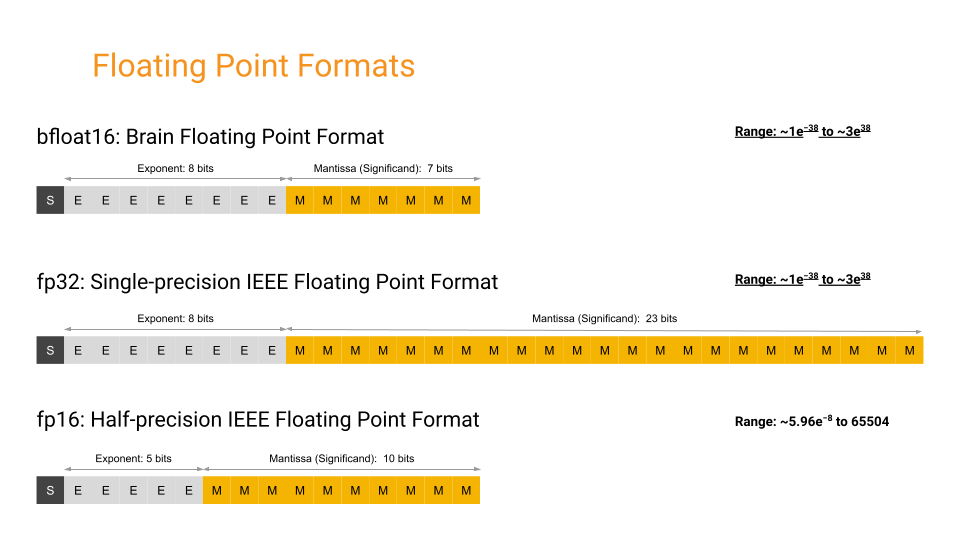

(出典：Google Cloud https://cloud.google.com/tpu/docs/bfloat16)

In [ ]:
training_args = TrainingArguments(
    output_dir='./outputs',
    num_train_epochs=1,  # エポック数
    per_device_train_batch_size=4,  # バッチサイズ
    gradient_accumulation_steps=4,  # 勾配累積のサイズ
    gradient_checkpointing=True,  # 勾配チェックポイント
    fp16=True,  # fp16
    logging_steps=100,  # 途中経過を表示する間隔
    save_steps=300 # 保存する間隔
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset
)

In [ ]:
result = trainer.train()
print_summary(result)

### オプティマイザ
オプティマイザの選択により、メモリの使用量を削減できる場合もあリます。

[Adafactor](https://arxiv.org/abs/1804.04235)はAdamと比較して、重み行列の各要素の移動平均を保持する代わりに、集約された情報（移動平均の行と列の合計）のみを保存するなどの工夫で、メモリの使用量を抑えることができるオプティマイザです。

Trainerの場合`optim`という引数に`adafactor`を設定することで利用することができます。

In [ ]:
training_args = TrainingArguments(
    output_dir='./outputs',
    num_train_epochs=1,  # エポック数
    per_device_train_batch_size=4,  # バッチサイズ
    gradient_accumulation_steps=4,  # 勾配累積のサイズ
    gradient_checkpointing=True,  # 勾配チェックポイント
    fp16=True,  # fp16
    optim='adafactor',  # オプティマイザの種類
    logging_steps=100,  # 途中経過を表示する間隔
    save_steps=300 # 保存する間隔
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset
)

In [ ]:
result = trainer.train()
print_summary(result)

### Deepspeed
また、シングルGPUでは用途が限られるが、Deepspeedの利用法についても述べます。

シングルGPUでDeepspeedを用いる場合は、CPUに余分なパラメータをオフロードして、大きなモデルを扱う用途が一般的です。

Trainerの場合`deepspeed`という引数にconfigへのパスを設定することで利用することができます。

In [ ]:
training_args = TrainingArguments(
    output_dir='./outputs',
    num_train_epochs=1,  # エポック数
    per_device_train_batch_size=4,  # バッチサイズ
    gradient_accumulation_steps=4,  # 勾配累積のサイズ
    gradient_checkpointing=True,  #勾配チェックポイント
    fp16=True,  #fp16
    optim='adafactor',  # オプティマイザの種類
    deepspeed='./ds_config.json',  # deepspeedのconfigへのpath
    logging_steps=100,  # 途中経過を表示する間隔
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset
)

In [ ]:
result = trainer.train()
print_summary(result)

## 参考
- [The Technology Behind BLOOM Training](https://huggingface.co/blog/bloom-megatron-deepspeed)：大規模なモデル開発についてのブログ記事
- [ABCI グランドチャレンジ参加報告](https://drive.google.com/file/d/18wMZFRphuwRwOfeDmVlnBxxVOKjt1PVw/view)：日本語での大規模なモデル開発についての記事
- [Train With Mixed Precision](https://docs.nvidia.com/deeplearning/performance/mixed-precision-training/index.html)：混合精度トレーニングに関する解説
- [Efficient Training on Multiple GPUs](https://huggingface.co/docs/transformers/perf_train_gpu_many)：マルチGPUでのモデルの並列技術を含めたより詳細な解説